# Ensemble Learning(앙상블 학습 방법)

* 앙상블(ensemble): 머신 러닝에서 사용되는 일련의 모델(알고리즘)들 
    * 서로 다른 알고리즘 여러개를 훈련시키는 방법
    * 같은 알고리즘을 서로 다른 훈련 셋에서 훈련시키는 방법 

* 앙상블 학습 방법: 앙상블을 사용한 머신러닝 방법
    * 투표(voting) 방식: 여러 모델을 학습시켜서 각각의 예측값을 투표(다수결) 또는 평균으로 예측하는 학습 방법
    * Bagging(Bootstrap Aggregating): **중복을 허용해서 샘플링**한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측(다수결, 평균) 
    * Pasting: **중복을 허용하지 않고 샘플링**한 훈련 셋의 부분집합들을 하나의 알고리즘에 훈련시켜서 예측하는 학습 방법

* Random Forest: Bagging을 사용한 Decision Tree의 Ensemble 학습 방법

# Imports

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier  # Exreme Gradient Boosting 
from lightgbm import LGBMClassifier 

# Data

In [57]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

In [13]:
X.shape, y.shape

((500, 2), (500,))

In [14]:
X[:5]  # data

array([[ 0.83067643, -0.40993581],
       [ 0.79835529,  0.83761218],
       [ 1.05046846, -0.48516193],
       [-0.25814276,  0.98000844],
       [ 0.3306816 ,  1.14763307]])

In [15]:
y[:5]  # target 

array([1, 0, 1, 0, 0])

In [16]:
np.unique(y)  # 0, 1 분류

array([0, 1])

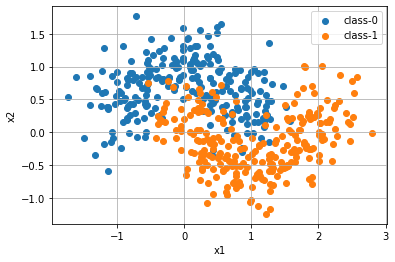

In [58]:
# 타겟 y 값에 따라서 다른 색상으로 산점도 
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='class-0') 
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='class-1') 

plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()
plt.show()

# Train/Test Split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y, 
                                                    random_state=42)

In [61]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400,), (100,))

# 머신러닝 모델 비교 

* 약한 학습기(weak learner) 여러개를 훈련 셋(X_train)으로 훈련 
    * LogisticRegression, SGDClasifier, SVC, DecisionTreeClassifier
* 각 학습기를 테스트 셋(X_test, y_test)으로 평가 - score 계산 

In [79]:
# 4개의 머신 러닝 모델(학습기) 생성
log_clf = LogisticRegression(random_state=42)
sgd_clf = SGDClassifier(loss='log')
svm_clf = SVC(probability=True, random_state=42)
tree_clf = DecisionTreeClassifier(random_state=42)
knn_clf = KNeighborsClassifier()

In [80]:
classifiers = [log_clf, sgd_clf, svm_clf, tree_clf, knn_clf]
for clf in classifiers: 
    clf.fit(X_train, y_train)  # 모델 훈련
    acc = clf.score(X_test, y_test) # 모델 평가 
    print(clf.__class__.__name__, 'accuracy:', acc)

LogisticRegression accuracy: 0.81
SGDClassifier accuracy: 0.82
SVC accuracy: 0.93
DecisionTreeClassifier accuracy: 0.84
KNeighborsClassifier accuracy: 0.93


# Voting Ensemble

In [86]:
# voting ensemble 학습기 생성
vote_clf = VotingClassifier(estimators=[('log', log_clf), 
                                        ('sgd', sgd_clf), 
                                        ('svm', svm_clf), 
                                        ('tree', tree_clf), 
                                        ('knn', knn_clf)], 
                            voting='soft', 
                            n_jobs=-1)

VotingClassifier의 파라미터
* estimators: ('모델이름', 모델객체) 튜플들의 리스트
* voting: 투표 방식
    * hard: 기본값. 모든 추정기(estimator)까 동일하게 1표씩 행사
    * soft: 각 추정기의 예측값에 그 예측의 확률을 가중치로 곱한 값을 사용해서 투표하는 방식. 확률이 더 높은 예측값이 더 높은 가중치를 가지고 투표를 하게 되는 방식
    * 일반적으로 soft voting 방식이 성능이 더 좋다고 알려져 있음
    * soft voting을 사용하려면 모든 예측기들이 예측 확률을 계산할 수 있어야 함. (svm에서 Probability=True 준 이유)

In [87]:
# 모델 학습
vote_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('log',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('sgd',
                              SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stoppin...
                                                     min_

In [88]:
# 모델 평가
vote_clf.score(X_test, y_test)
#> voting='hard'인 경우 score=0.89 

0.91

# Bagging(Bootstrap Aggregating) Ensemble

In [89]:
tree_clf = DecisionTreeClassifier(random_state=42)

BaggingClassifier의 파라미터
* base_estimator: 기본 추정기(예측기). 머신 러닝 알고리즘 객체
* n_estimators: 추정기(예측기) 개수 = 모델 학습 횟수 = 훈련 셋 부분집합 개수. 기본값은 10
* max_samples: 훈련 셋의 부분 집합이 가질 수 있는 최대 원소 개수(또는 비율). 기본 값은 1.0
* bootstrap: True(중복 허용 샘플링. Bagging), False(중복 불허 샘플링. Pasting). 기본값은 True
* oob_score: OOB 샘플로 모델을 평가할 것인지(True), 아닌지(False)를 설정. 기본값은 True
    * OOB(Out-of-Bag) 샘플 : 중복 허용해서 부분집합을 만드는 동안에 한번도 샘플링되지 못한 훈련 셋의 샘플
    * OOB 샘플을 검증 셋(validation set)으로 이용할 수도 있다


In [95]:
# Bagging 분류기 객체 생성
bagging_clf = BaggingClassifier(base_estimator=tree_clf, 
                                n_estimators=100,
                                max_samples=100,
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42)

In [96]:
# 모델 훈련
bagging_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
  

In [97]:
# 모델 평가
bagging_clf.score(X_test, y_test)

0.91

In [98]:
# OOB score
bagging_clf.oob_score_  #> 보통 테스트 셋의 점수와 비슷

0.905

# Random Forest

Random Forest: Decision Tree를 예측기로 사용하는 Bagging Ensemble 학습 방법
* RandomForestClassifier 클래스는 DeicisionTreeClassifier의 파라미터와 BaggingClassifier 클래스의 파라미터들을 가지고 있음 
* GridSearchCV, RandomizedSearchCV를 이용해서 tree와 bagging의 파라미터들을 튜닝할 수 있다

In [103]:
# 모델 생성
forest_clf = RandomForestClassifier(n_estimators=50,
                                    max_samples=100, 
                                    oob_score=True,
                                    n_jobs=-1, 
                                    random_state=42)

In [104]:
# 모델 훈련
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [106]:
forest_clf.oob_score_  # OOB 샘플 평가

0.9125

In [107]:
# 테스트 셋 평가
forest_clf.score(X_test, y_test)

0.91

In [108]:
# random forest는 decision tree와 마찬가지로 특성들의 중요도를 측정할 수 있음 
forest_clf.feature_importances_

array([0.43595463, 0.56404537])

# Wine Data 분류

In [109]:
wine = pd.read_csv('https://bit.ly/wine-date')

In [110]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [112]:
X = wine.drop(columns='class').to_numpy()
y = wine['class'].to_numpy()  # target

In [113]:
X[:5]

array([[9.4 , 1.9 , 3.51],
       [9.8 , 2.6 , 3.2 ],
       [9.8 , 2.3 , 3.26],
       [9.8 , 1.9 , 3.16],
       [9.4 , 1.9 , 3.51]])

In [114]:
y[:5]

array([0., 0., 0., 0., 0.])

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [116]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5197, 3), (1300, 3), (5197,), (1300,))

## Random Forest

In [124]:
forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)  # 모델 생성

In [126]:
forest_clf.fit(X_train, y_train) # 모델 훈련 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [127]:
forest_clf.score(X_test, y_test)  # 테스트 셋 점수

0.8892307692307693

In [128]:
forest_clf.score(X_train, y_train)  # 훈련 셋 점수

0.9978833942659227

In [129]:
forest_clf.feature_importances_  # 특성 중요도

array([0.2301315 , 0.50081183, 0.26905668])

In [131]:
forest_clf.oob_score_  # OOB 샘플들의 점수로 일반화 점수를 예측해 볼 수 있다 

0.8964787377333077

## Extra Tree

* Random Forest와 비슷한 점: 
    * 여러개(기본값 100개)의 decision tree를 훈련 
    * decision tree의 대부분의 파라미터들을 튜닝할 수 있음 
    * 전체 특성들 중 일부 특성들을 랜덤하게 선택해서 노드를 분할하는데 사용
* Random Forest와 다른 점: 
    * Bootstrap 샘플을 사용하지 않음. 여러 개의 decision tree를 전체 훈련 셋을 사용해서 훈련 시킴
    * 노드를 분할할 때 ***가장 좋은 분할***을 찾는 것이 아니라, ***무작위 분할***을 함
        * Random Forest보다 더 많은 decision tree를 사용해서 훈련해야 좋은 성능을 낼 수 있음 
        * Random Forest는 최적의 분할을 찾기 위해 많은 훈련 시간이 필요
        * Extra Tree는 훈련 시간이 빠르다 

In [135]:
tree_clf = DecisionTreeClassifier(splitter='random', random_state=42)
scores = cross_val_score(tree_clf, X_train, y_train)
np.mean(scores)
#> splitter='best'인 경우, 0.857

0.852218849485452

In [139]:
extra_tree_clf = ExtraTreesClassifier(n_jobs=-1, random_state=42)

In [140]:
extra_tree_clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [142]:
extra_tree_clf.score(X_train, y_train)

0.9978833942659227

In [143]:
extra_tree_clf.score(X_test, y_test)

0.8792307692307693

## Gradient Boosting

Gradient Boosting Decision Tree(GBDT)

* 깊이(depth)가 얕은 tree들을 직렬로 연결해서 훈련 
* 깊이가 얕은 tree를 사용하기 때문에 과대적합에 강하고 높은 일반화 성능을 기대할 수 있음 
* Random Forest 처럼 병렬로 훈련시킬 수 없음. n_job 파라미터가 없음. 훈련 속도가 느린 단점
* Gradient Descent + Tree + Ensemble의 파라미터들을 튜닝할 수 있음 

In [144]:
gb_clt= GradientBoostingClassifier(random_state=42)

In [145]:
gb_clt.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [146]:
gb_clt.score(X_train, y_train)

0.8833942659226477

In [147]:
gb_clt.score(X_test, y_test)

0.8576923076923076

## XGBoost 

In [148]:
xg_clt = XGBClassifier(random_state=42)

In [149]:
xg_clt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [150]:
xg_clt.score(X_train, y_train)

0.878968635751395

In [151]:
xg_clt.score(X_test, y_test)

0.8546153846153847

## LightGBM

In [152]:
lg_clt = LGBMClassifier(random_state=42)

In [153]:
lg_clt.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [154]:
lg_clt.score(X_train, y_train)

0.9239946122763133

In [155]:
lg_clt.score(X_test, y_test)

0.8761538461538462